# **Store Item Demand Forecasting Challenge**


This case study is part of the kaggle competition “Store Item Demand Forecasting
Challenge” . We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores .


This is a time series problem
where we have to try different time series techniques to arrive at the best score.


Submissions are evaluated on SMAPE between forecasts and actual values.Here SMAPE=0
when the actual and predicted values are both 0.


## **Data Set**

Data fields :
*  date - Date of the sale data. There are no holiday effects or store closures.
*  store - Store ID
*  item - Item ID
*  sales - Number of items sold at a particular store on a particular date.









# **1.** **Reading Data**

## **1.1 Loading Data**

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir("/content/gdrive/My Drive/store/")
cwd = os.getcwd()
print(cwd)

/content/gdrive/My Drive/store


In [ ]:
# loading train and test data set
store_data = pd.read_csv('train.csv', parse_dates=['date'], index_col=['date'])
test_data = pd.read_csv('test.csv', parse_dates=['date'], index_col=['date'])

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
store_data.shape

(913000, 3)

In [ ]:
test_data.shape

(45000, 3)

In [ ]:
store_data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
test_data.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


## **1.2 Checking for null values**

In [ ]:
# checking for null values in store_data

print(store_data.isnull().any())

store    False
item     False
sales    False
dtype: bool


In [ ]:
# checking for null values in test_data

print(test_data.isnull().any())

id       False
store    False
item     False
dtype: bool


No null values found

## **1.3 Checking for outliers**

We are using percentile approach to determine outliers

In [ ]:
Q0 = store_data.quantile(0)
Q1 = store_data.quantile(.01)
Q50 = store_data.quantile(.5)
Q99 = store_data.quantile(.99)
Q100= store_data.quantile(1)

In [ ]:
#range of values for store column.We are checking 0th and 100th percentile values here.
print(Q0[0],Q100[0])

1.0 10.0


Store values should range from 1-10.No outlier in store column

In [ ]:
#range of values for item column.We are checking 0th and 100th percentile values here.
print(Q0[1],Q100[1])

1.0 50.0


Item values should range from 1-50.No outlier in item column

In [ ]:
#range of values for sales column . We are checking 0th,1th,50th,99th and 100th percentile values here.
print(Q0[2],Q1[2],Q50[2],Q99[2],Q100[2])

0.0 10.0 47.0 135.0 231.0


Sales values seems expected.No outlier in sales column

# **2. EDA**

## **2.1 Monthly Sales EDA for stores(1-10)**

Here we are checking for importance of seasonality as a factor.Lets combine sales for each month and plot them for each store.

In [ ]:
store_data['day'] = store_data.index.day
store_data['month'] = store_data.index.month
store_data['year'] = store_data.index.year
store_data['dayofweek'] = store_data.index.dayofweek

In [ ]:
test_data['day'] = test_data.index.day
test_data['month'] = test_data.index.month
test_data['year'] = test_data.index.year
test_data['dayofweek'] = test_data.index.dayofweek

In [ ]:
store_data.head(5)

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [ ]:
store_sales_monthly_sum = {}
store_sales_monthly_plot = {}
for store in range(1,11) :
  store_sales_monthly_sum[store] = []
  store_sales_monthly_plot[store] = []
  for year in range(2013,2018) :
    for month in range(1,13) :
      store_sales_monthly = store_data[(store_data["month"] == month) & (store_data["year"] == year)]
      store_sales_monthly_sum[store].append(store_sales_monthly["sales"].sum())
      store_sales_monthly_plot[store].append(str(year)+"-"+str(month))

In [ ]:
print(store_sales_monthly_sum)

{1: [454904, 459417, 617382, 682274, 763242, 795597, 855922, 766761, 689907, 656587, 692643, 506607, 525987, 529117, 704301, 788914, 882877, 906842, 989010, 885596, 785124, 758883, 800783, 578048, 552513, 551317, 730951, 824467, 926902, 937184, 1037350, 920401, 823332, 797253, 827645, 607572, 602439, 614957, 790881, 901950, 988730, 1022664, 1138718, 981494, 896831, 863637, 891448, 663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170], 2: [454904, 459417, 617382, 682274, 763242, 795597, 855922, 766761, 689907, 656587, 692643, 506607, 525987, 529117, 704301, 788914, 882877, 906842, 989010, 885596, 785124, 758883, 800783, 578048, 552513, 551317, 730951, 824467, 926902, 937184, 1037350, 920401, 823332, 797253, 827645, 607572, 602439, 614957, 790881, 901950, 988730, 1022664, 1138718, 981494, 896831, 863637, 891448, 663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170], 3: [454904, 459

In [ ]:
print(store_sales_monthly_plot)

{1: ['2013-1', '2013-2', '2013-3', '2013-4', '2013-5', '2013-6', '2013-7', '2013-8', '2013-9', '2013-10', '2013-11', '2013-12', '2014-1', '2014-2', '2014-3', '2014-4', '2014-5', '2014-6', '2014-7', '2014-8', '2014-9', '2014-10', '2014-11', '2014-12', '2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6', '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8', '2017-9', '2017-10', '2017-11', '2017-12'], 2: ['2013-1', '2013-2', '2013-3', '2013-4', '2013-5', '2013-6', '2013-7', '2013-8', '2013-9', '2013-10', '2013-11', '2013-12', '2014-1', '2014-2', '2014-3', '2014-4', '2014-5', '2014-6', '2014-7', '2014-8', '2014-9', '2014-10', '2014-11', '2014-12', '2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6', '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12', '2016-

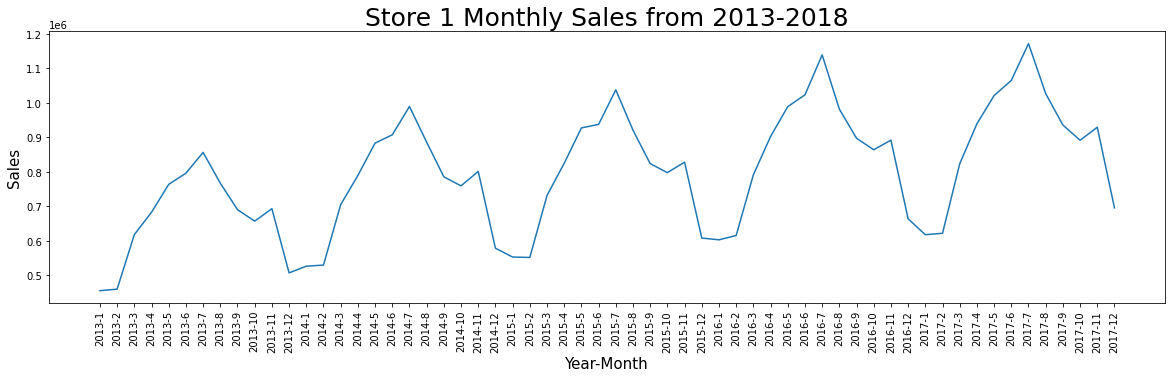

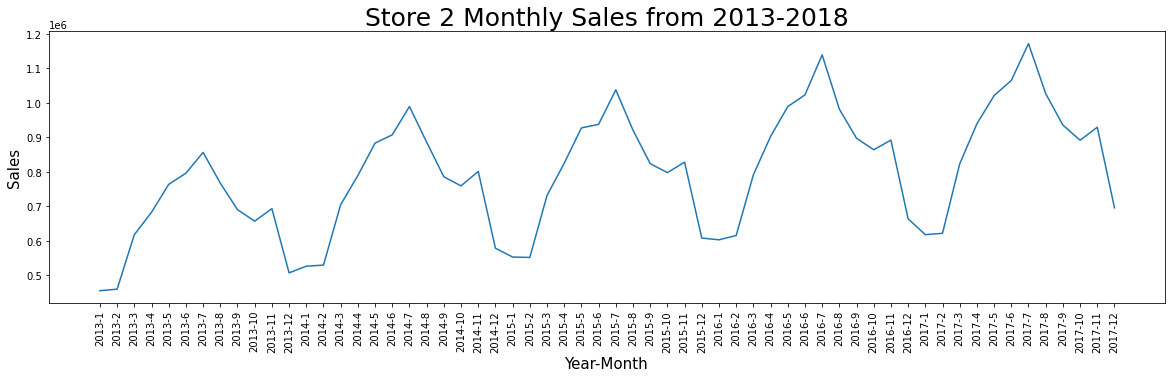

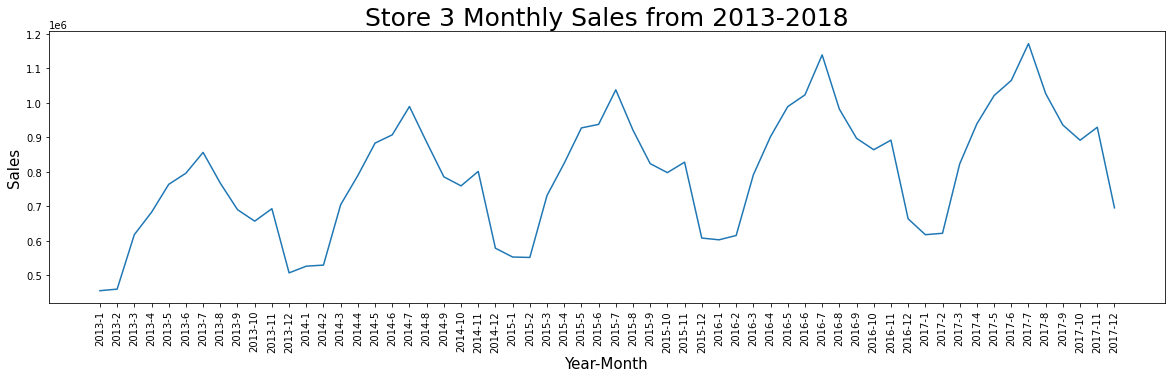

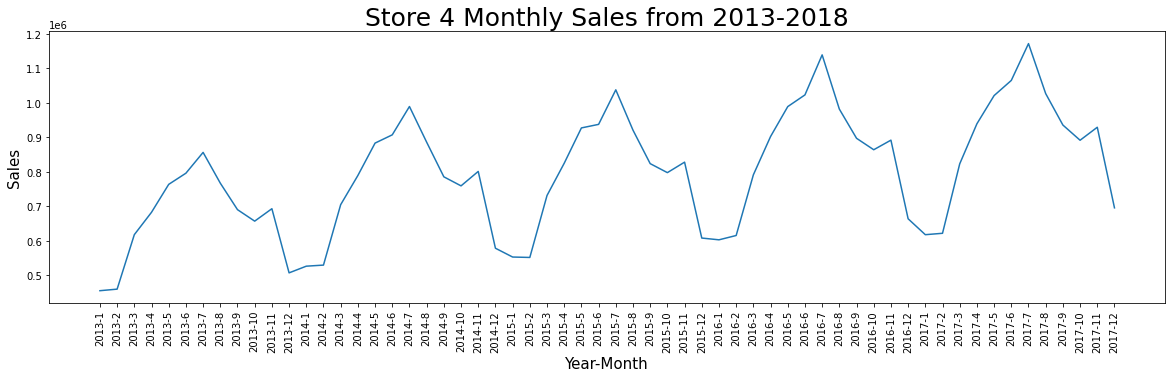

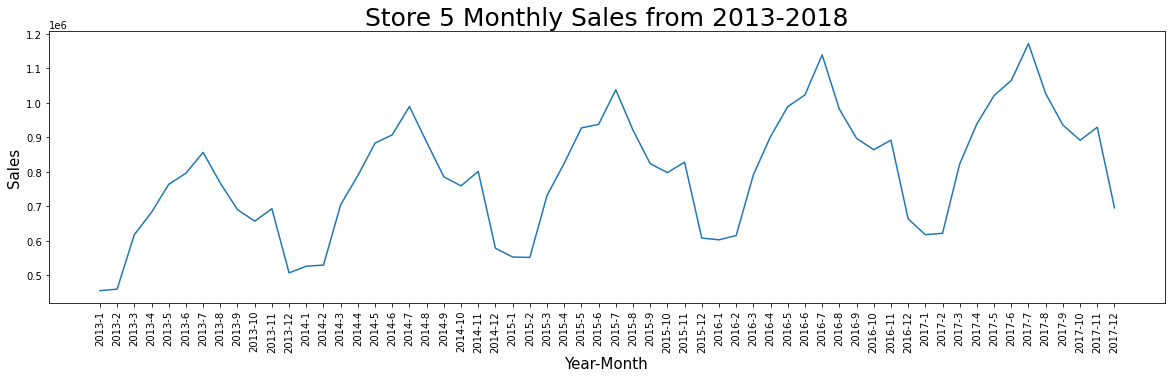

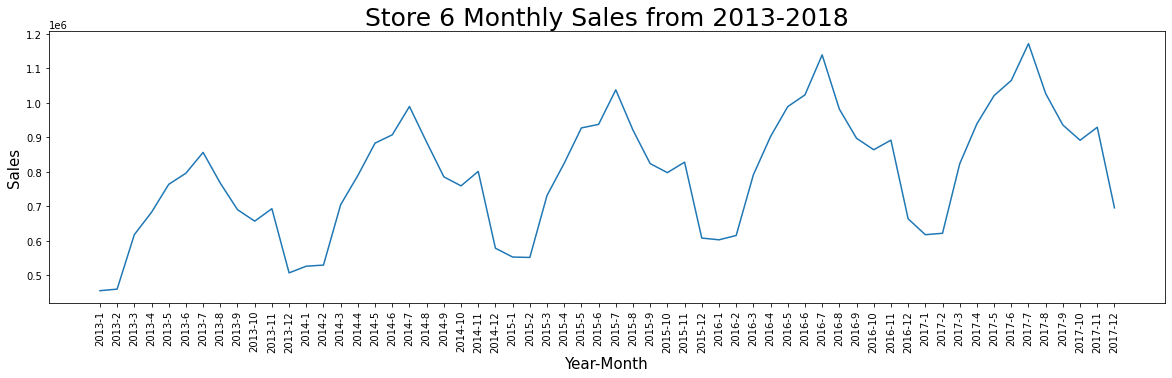

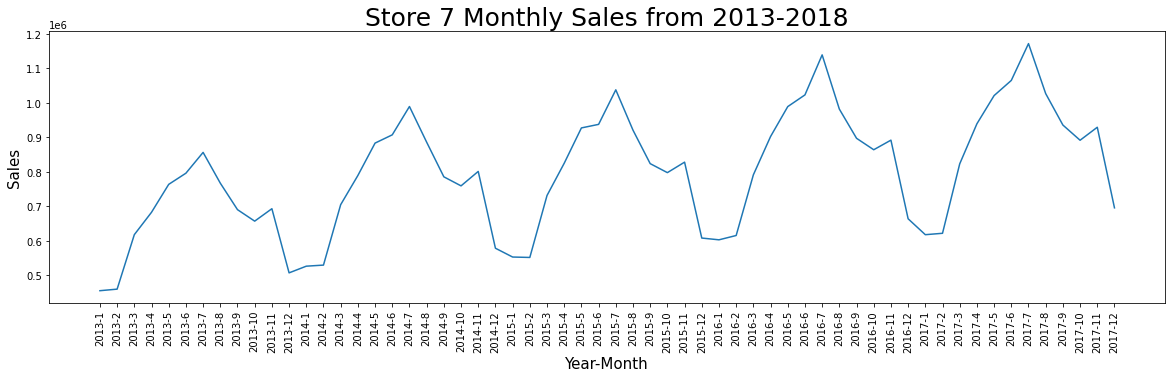

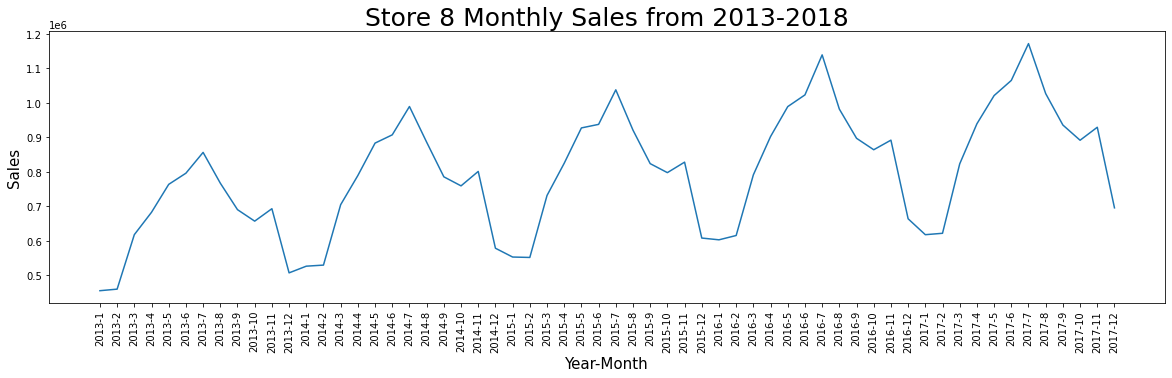

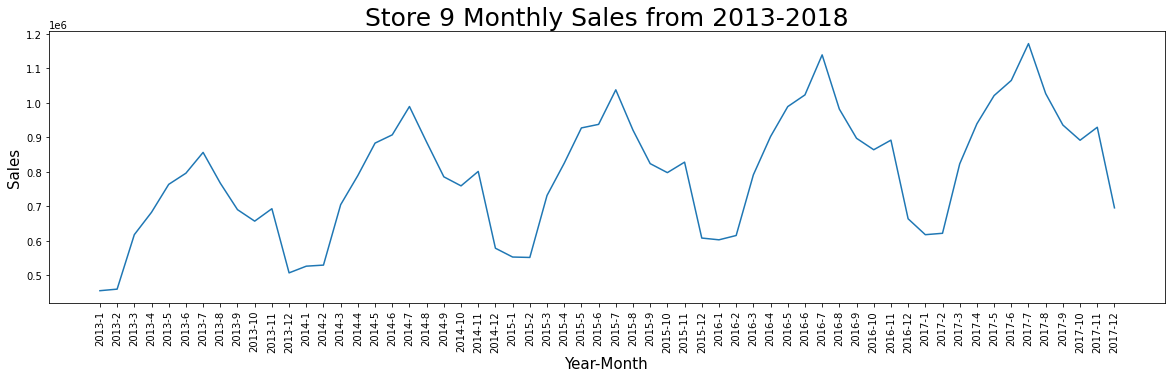

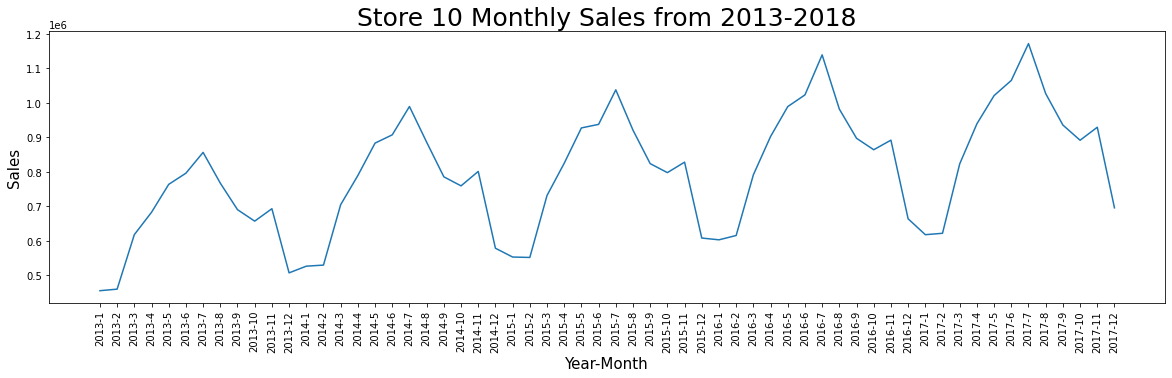

In [ ]:
for store in range(1,11) :
  plt.figure(figsize=(20,5))
  plt.plot(store_sales_monthly_plot[store], store_sales_monthly_sum[store])
  plt.xlabel("Year-Month",fontsize=15)
  plt.ylabel("Sales",fontsize=15)
  plt.title('Store '+str(store)+' Monthly Sales from 2013-2018', fontsize=25)
  plt.xticks(rotation=90)
  plt.show()

**We can see seasonality is important factor here. Sales for all store(1-10) is showing definte trends month wise for each of the years(2013-2018).Sales is follwing same pattern of increasing till month of july then decreasing for every store. And, we are seeing same pattern for every year(2013-2018) .**

**As we can see that "store monthly sales" are related with four seasons(winter,spring ,summer and fall):**

1. In winter season(dec,jan and feb) - we see lowest sales. 

2. Then sales follow increasing trend in spring(march,april and may). 

3. The sales reach peak in summer months(june,july,august). 

4. Then again there is decrease in sales in autumn(sept,oct,nov). In month of november there is slight upward sales comapre to sept and oct.
The reason for this can be either it is holiday season or stores give promotion sales or some other reason .

**So, we see lowest  and highest sales in winter and summer months respectively.
And sales in autumn and spring is in between these two seasons .**

## **2.2 Items(1-50) Sales EDA for stores(1-10)**

For every store we are plotting total sales across items(1-50)

In [ ]:
store_data_item_sales = {}
for store in range(1,11) :
  store_data_item_sales[store] = []
  for item in range(1,51) : 
    item_sales_store = store_data[(store_data["item"] == item) & (store_data["store"] == store)]
    item_sales_store_avg = item_sales_store["sales"].mean()
    store_data_item_sales[store].append(item_sales_store_avg)

In [ ]:
print(store_data_item_sales)

{1: [19.971522453450163, 53.14895947426068, 33.20810514786418, 19.95618838992333, 16.612814895947427, 53.06078860898138, 52.78368017524644, 69.47207009857613, 46.50492880613363, 66.35432639649507, 63.217962760131435, 63.23384446878423, 76.1593647316539, 53.14895947426068, 79.68072289156626, 23.332420591456735, 29.972070098576122, 76.34556407447974, 36.67688937568455, 42.89047097480832, 36.1763417305586, 72.78148959474261, 26.46987951807229, 60.0, 72.73603504928806, 43.23603504928806, 20.05093099671413, 79.56681270536693, 63.08652792990142, 36.31818181818182, 53.008214676889374, 39.83789704271632, 62.755750273822564, 23.274917853231106, 59.49507119386637, 69.30996714129245, 26.424424972617743, 73.34446878422781, 39.69496166484118, 26.44359255202629, 20.00273822562979, 33.10569550930997, 46.24260679079956, 26.59419496166484, 72.72070098576123, 52.84501642935378, 19.81434830230011, 46.5460021905805, 26.461664841182913, 59.34282584884995], 2: [28.173603504928806, 75.31653888280394, 46.9923

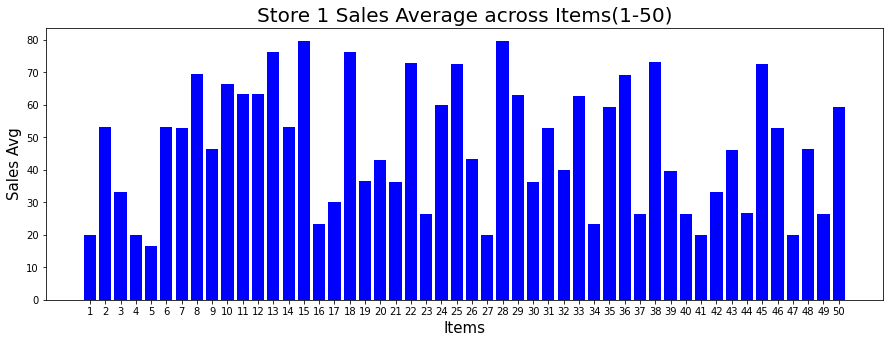

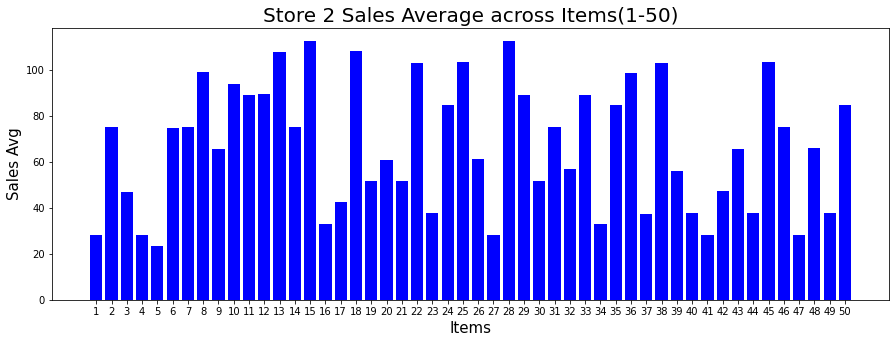

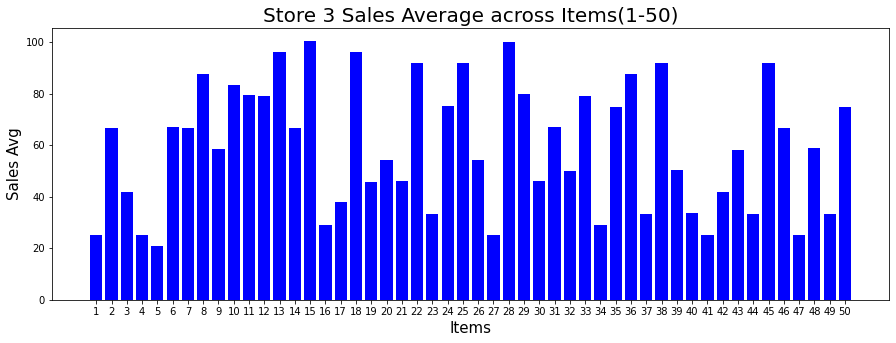

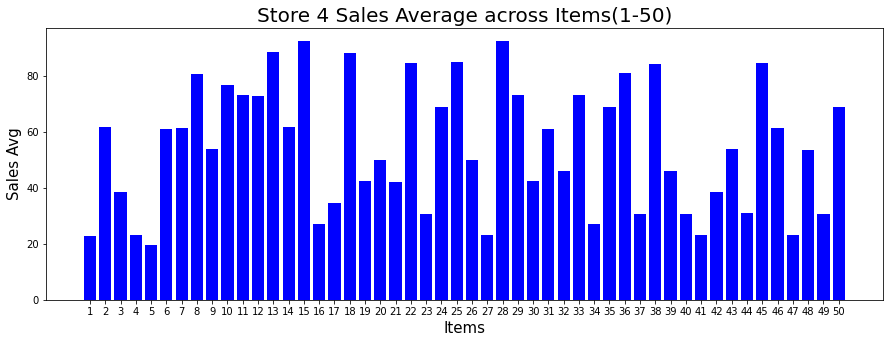

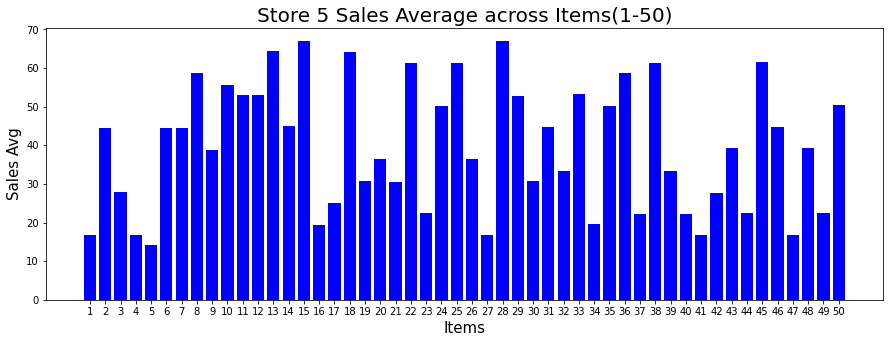

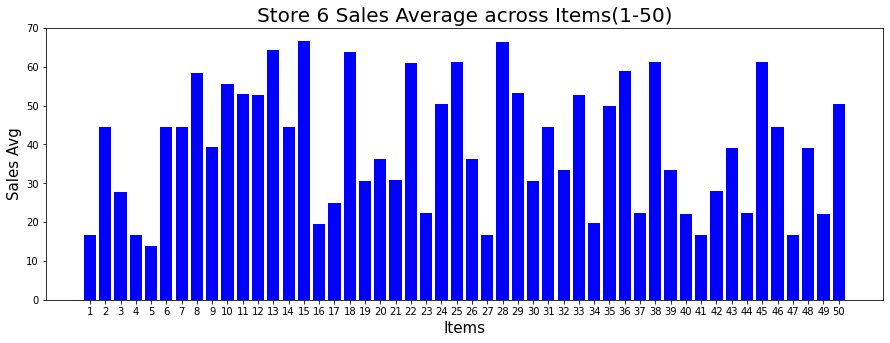

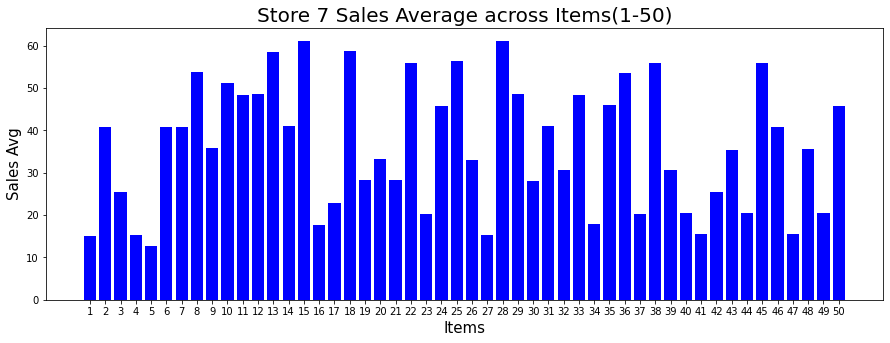

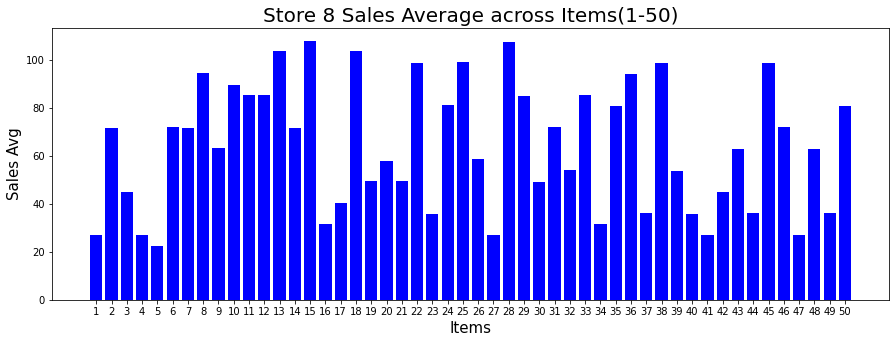

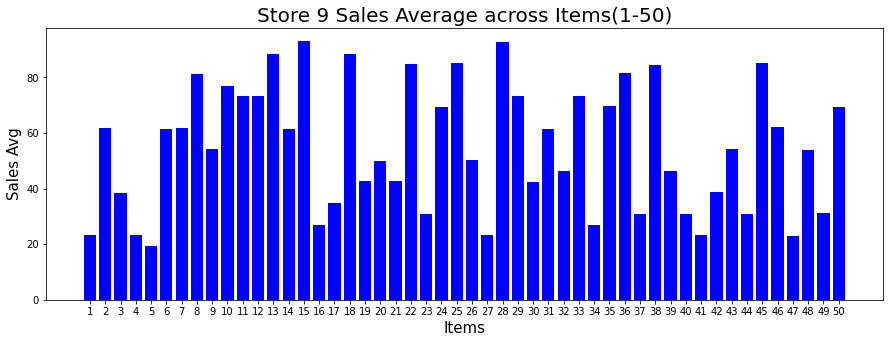

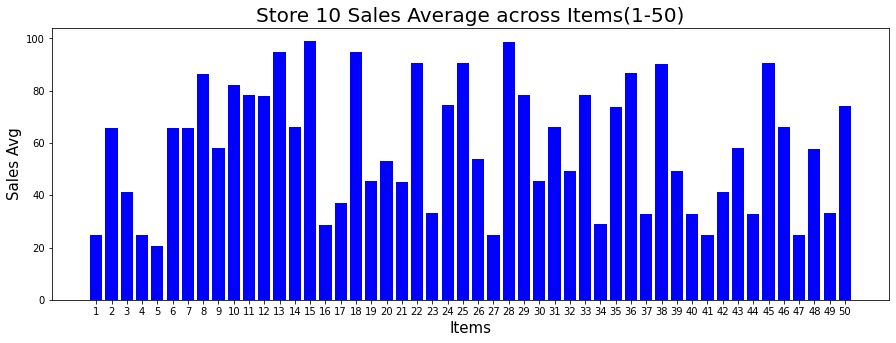

In [ ]:
items = range(1,51)
for store in range(1,11):
    plt.figure(figsize=(15,5))
    plt.bar(items, store_data_item_sales[store], color='blue')
    plt.xlabel("Items",fontsize=15)
    plt.ylabel("Sales Avg",fontsize=15)
    plt.title('Store '+str(store)+' Sales Average across Items(1-50)', fontsize=20)
    plt.xticks(items)
    plt.show()


**We see same pattern across all the stores. Each item contribute  same portion of sales for each of the stores.**

**If we observe sale of items(1-50) across each store .We can see that following items have similar sales:**

1. Item 1,4 27,41,47
2. Item 2,6,7,14,31,46
3. Item 3,42
4. Item 8,36
5. Item 9,43,48
6. Item 11,12,29,33
7. Item 13,18
8. Item 15,28
9. Item 16,34
10. Item 19,21,30
11. Item 20,26
12. Item 22,25,38,45
13. Item 23,37,40,44,49
14. Item 24,35,50
15. Item 32,39

**Group 8(15,28) has highest sales. Group 1(1,4 27,41,47) has lowest sales.**

**We have completed  EDA of both monthly sales and item sales.So, we are now moving to feature engineering part.**

#  **3.Feature Engineering**

In [ ]:
store_data.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [ ]:
test_data.head()

,id,store,item,day,month,year,dayofweek
date,,,,,,,
2018-01-01,0,1,1,1,1,2018,0
2018-01-02,1,1,1,2,1,2018,1
2018-01-03,2,1,1,3,1,2018,2
2018-01-04,3,1,1,4,1,2018,3
2018-01-05,4,1,1,5,1,2018,4


##   **3.1  Sales prediction 2018 using drift method(quardatic function and pivot tables)**

In [ ]:
'''
Calculating 2018 sales values using values from past (2013-1017).
First fiding out year-by-year growth using yearly sales average(2013-2017).
Then map them on approximate quardatic function which will give us projected growth value for 2018. 

Then calulating averge sales on dayofweek,monthly and store wise basis(using pivot tables).Overall average sale value is used as normalizer.
Multiply these values with 2018 projected yearly growth.This will give us sales value for year 2018.

'''

'\nCalculating 2018 sales values using values from past (2013-1017).\nFirst fiding out year-by-year growth using yearly sales average(2013-2017).\nThen map them on approximate quardatic function which will give us projected growth value for 2018. \n\nThen calulating averge sales on dayofweek,monthly and store wise basis(using pivot tables).Overall average sale value is used as normalizer.\nMultiply these values with 2018 projected yearly growth.This will give us sales value for year 2018.\n\n'

In [ ]:
#Overall average sale value
average = store_data.sales.mean()
print(average)

52.250286966046005


In [ ]:
# Pivot Table on year index
year_pivot_table = pd.pivot_table(store_data, index='year', values='sales', aggfunc=np.mean) / average


In [ ]:
year_pivot_table.head()

,sales
year,
2013,0.832793
2014,0.958032
2015,1.000127
2016,1.083181
2017,1.125640


In [ ]:
#approximate quardatic function
store_years = np.arange(2013, 2019)
weight = np.exp((store_years - 2018) / 10)[:-1]
store_annual_growth = np.poly1d(np.polyfit(store_years[:-1], year_pivot_table.values.squeeze(), 2, w=weight))

In [ ]:
store_annual_growth

poly1d([-8.27164735e-03,  3.34057399e+01, -3.37267999e+04])

In [ ]:
# Pivot Table on Day of Week index
dayofweek_pivot_table = pd.pivot_table(store_data, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)

In [ ]:
dayofweek_pivot_table.head()

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
dayofweek,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.462308,46.259231,29.104231,17.470769,14.463462,46.438462,46.325000,60.846538,40.952308,58.078462,55.166154,55.238846,66.909615,46.500769,69.952308,20.348462,26.220385,66.877308,31.903846,37.737308,31.911154,63.814615,23.218077,52.415769,63.771154,37.784615,17.441154,69.365385,55.531154,32.026923,46.534615,34.672692,55.273462,20.423077,51.923846,61.103462,23.313462,64.028846,34.686538,23.300385,17.455385,28.964615,40.889615,23.203077,63.778846,46.541923,17.481154,40.695000,23.300385,52.375769
1,20.279693,54.256705,33.739080,20.363218,16.858238,53.914943,54.066667,71.183142,47.521456,67.409962,64.201533,64.199234,78.162452,54.241762,81.365134,23.708046,30.499234,77.566284,37.142912,43.959004,37.197318,74.290421,27.094253,61.145977,74.431034,44.115326,20.448659,81.079310,64.255172,37.341762,54.132567,40.595019,64.345211,23.801533,60.707663,71.032567,27.142912,74.054789,40.505747,26.923755,20.338697,33.914559,47.059004,27.321839,74.238314,54.097701,20.273180,47.132950,27.016475,60.622989
2,20.414176,54.191954,33.975479,20.401533,17.075862,54.054023,54.224521,71.054406,47.455172,67.958621,64.512261,64.388889,78.188889,54.350575,81.493487,23.680460,30.563218,77.958621,37.488506,43.973563,37.284291,74.496169,27.216475,61.097318,74.790421,44.021456,20.550192,81.392337,64.524904,37.205747,54.507280,40.866667,64.047893,23.626437,60.899617,71.115709,26.914176,74.619923,40.908429,27.040230,20.388889,34.005364,47.505364,27.085441,74.570881,54.020307,20.468199,47.499617,27.165517,61.185824
3,21.687356,58.108046,36.135632,21.818008,18.238697,57.740613,58.172414,75.997318,50.629119,72.445977,68.758238,68.980077,83.423372,58.201533,87.265134,25.370881,32.803831,83.665517,40.238314,47.059387,40.087356,79.336398,29.084291,65.267050,79.804981,47.042146,21.832184,87.309579,68.737548,39.781609,57.912644,43.729119,68.678927,25.452107,65.087356,76.216475,28.946360,79.929119,43.274713,29.115326,21.675862,36.348659,50.873946,29.061686,79.711877,57.937165,21.773946,50.687356,29.178544,65.547126
4,23.245594,61.922989,38.783142,23.229119,19.473563,61.643295,61.581609,81.211111,54.247510,77.421839,73.829885,73.578544,88.913027,61.739080,92.682759,26.912644,34.780843,89.140996,42.357088,50.044444,42.589272,84.883908,30.899617,69.675862,85.345211,50.268966,23.266284,92.626054,73.485057,42.684674,61.900383,46.260920,73.444828,27.083142,69.468199,81.379310,30.708046,85.157471,46.313027,30.760536,23.336782,38.667050,54.220690,31.013793,85.357088,62.304981,23.058621,54.617241,30.972414,69.373946


In [ ]:
# Pivot Table on Month index
month_pivot_table = pd.pivot_table(store_data, index='month', values='sales', aggfunc=np.mean) / average

In [ ]:
month_pivot_table.head()

,sales
month,
1,0.679891
2,0.753649
3,0.905365
4,1.055552
5,1.131634


In [ ]:
# Pivot Table on Store index
store_pivot_table = pd.pivot_table(store_data, index='store', values='sales', aggfunc=np.mean) / average

In [ ]:
store_pivot_table.head()

,sales
store,
1,0.904653
2,1.282924
3,1.139335
4,1.050768
5,0.761147


In [ ]:
test_data.head()

,id,store,item,day,month,year,dayofweek
date,,,,,,,
2018-01-01,0,1,1,1,1,2018,0
2018-01-02,1,1,1,2,1,2018,1
2018-01-03,2,1,1,3,1,2018,2
2018-01-04,3,1,1,4,1,2018,3
2018-01-05,4,1,1,5,1,2018,4


In [ ]:
#Calculating 2018 sales values using pivot table values(Day of Week,Monthly and Store) and multiplying with 2018 growth rate.
sales_pred_2018 = []
for _, test_row in test_data.iterrows():
  dayofweek_row, month_row= test_row.name.dayofweek, test_row.name.month
  item_row, store_id_row = test_row['item'], test_row['store']

  #Calculating dayofweek,monthly and store value
  dayofweek_value = dayofweek_pivot_table.at[dayofweek_row, item_row]
  month_value = month_pivot_table.at[month_row, 'sales']
  sales_value =  store_pivot_table.at[store_id_row, 'sales']

  #muliplying all previous values
  final_product = dayofweek_value * month_value * sales_value
  store_annual_growth_value = store_annual_growth(2018)

  #muliplying with 2018 growth value
  sales_pred_2018.append(int(np.round(final_product * store_annual_growth_value, 0)))

In [ ]:
test_data['sales'] = sales_pred_2018
store = pd.concat([store_data, test_data], sort=False)
store.reset_index(inplace=True)

In [ ]:
store.head()

,date,store,item,sales,day,month,year,dayofweek,id
0,2013-01-01,1,1,13,1,1,2013,1,NaN
1,2013-01-02,1,1,11,2,1,2013,2,NaN
2,2013-01-03,1,1,14,3,1,2013,3,NaN
3,2013-01-04,1,1,13,4,1,2013,4,NaN
4,2013-01-05,1,1,10,5,1,2013,5,NaN


In [ ]:
store.tail()

,date,store,item,sales,day,month,year,dayofweek,id
957995,2018-03-27,10,50,71,27,3,2018,1,44995.0
957996,2018-03-28,10,50,72,28,3,2018,2,44996.0
957997,2018-03-29,10,50,77,29,3,2018,3,44997.0
957998,2018-03-30,10,50,82,30,3,2018,4,44998.0
957999,2018-03-31,10,50,87,31,3,2018,5,44999.0


In [ ]:
store.shape

(958000, 9)

In [ ]:
store_2018 = store[store['year'] == 2018]

In [ ]:
store_2018.reset_index(drop=True,inplace=True)

In [ ]:
store_2018.head()

,date,store,item,sales,day,month,year,dayofweek,id
0,2018-01-01,1,1,12,1,1,2018,0,0.0
1,2018-01-02,1,1,14,2,1,2018,1,1.0
2,2018-01-03,1,1,15,3,1,2018,2,2.0
3,2018-01-04,1,1,15,4,1,2018,3,3.0
4,2018-01-05,1,1,17,5,1,2018,4,4.0


In [ ]:
store_2018.to_csv('store_2018.csv', index=False)

## **3.2 Adding more date related features**

In [ ]:
store['dayofyear'] = store.date.dt.dayofyear
store['weekofyear'] = store.date.dt.weekofyear
store['weekend_yes'] = store.date.dt.weekday // 4
store['month_start_yes'] = store.date.dt.is_month_start.astype(int)
store['month_end_yes'] = store.date.dt.is_month_end.astype(int)
store['quarter'] = store.date.dt.quarter
store['weekofmonth'] = store['weekofyear'].values // 4.35                                                                                                                                                                               
store['mon_yes'] = np.where(store['dayofweek'] == 0, 1, 0)                                                                                            
store['tue_yes'] = np.where(store['dayofweek'] == 1, 1, 0)                                                                                         
store['wed_yes'] = np.where(store['dayofweek'] == 2, 1, 0)                                                                                         
store['thu_yes'] = np.where(store['dayofweek'] == 3, 1, 0)                                                                                         
store['fri_yes'] = np.where(store['dayofweek'] == 4, 1, 0)                                                                                         
store['sat_yes'] = np.where(store['dayofweek'] == 5, 1, 0)                                                                                         
store['sun_yes'] = np.where(store['dayofweek'] == 6, 1, 0) 

In [ ]:
store.head()

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes
0,2013-01-01,1,1,13,1,1,2013,1,NaN,1,1,0,1,0,1,0.0,0,1,0,0,0,0,0
1,2013-01-02,1,1,11,2,1,2013,2,NaN,2,1,0,0,0,1,0.0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14,3,1,2013,3,NaN,3,1,0,0,0,1,0.0,0,0,0,1,0,0,0
3,2013-01-04,1,1,13,4,1,2013,4,NaN,4,1,1,0,0,1,0.0,0,0,0,0,1,0,0
4,2013-01-05,1,1,10,5,1,2013,5,NaN,5,1,1,0,0,1,0.0,0,0,0,0,0,1,0


## **3.3 Adding  expanding  time features**

In [ ]:
exp_time_features = ['dayofweek', 'weekofmonth', 'weekofyear', 'month', 'quarter', 'weekend_yes'] 
for exp_item in exp_time_features:
    expanding_store = store.groupby(['store', 'item', exp_item])['sales'].expanding().mean().bfill().reset_index()
    expanding_store.columns = ['store', 'item', exp_item, 'exp_index', 'exp_'+exp_item]
    expanding_store = expanding_store.sort_values(by=['item', 'store', 'exp_index'])
    store['exp_'+exp_item] = expanding_store['exp_'+exp_item].values

In [ ]:
store.head()

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes
0,2013-01-01,1,1,13,1,1,2013,1,NaN,1,1,0,1,0,1,0.0,0,1,0,0,0,0,0,13.0,13.000000,13.000000,13.000000,13.000000,13.000000
1,2013-01-02,1,1,11,2,1,2013,2,NaN,2,1,0,0,0,1,0.0,0,0,1,0,0,0,0,11.0,12.000000,12.000000,12.000000,12.000000,12.000000
2,2013-01-03,1,1,14,3,1,2013,3,NaN,3,1,0,0,0,1,0.0,0,0,0,1,0,0,0,14.0,12.666667,12.666667,12.666667,12.666667,12.666667
3,2013-01-04,1,1,13,4,1,2013,4,NaN,4,1,1,0,0,1,0.0,0,0,0,0,1,0,0,13.0,12.750000,12.750000,12.750000,12.750000,13.000000
4,2013-01-05,1,1,10,5,1,2013,5,NaN,5,1,1,0,0,1,0.0,0,0,0,0,0,1,0,10.0,12.200000,12.200000,12.200000,12.200000,11.500000


In [ ]:
store.shape

(958000, 29)

## **3.4 Adding Lag, Rolling Mean and Exponentially Mean Features**

In [ ]:
#Lag(l),Rolling(r) and Aplha(a) values are used from another kaggle notebook.

In [ ]:
store.sort_values(by=['item', 'store', 'date'], axis=0, inplace=True)

In [ ]:
#Adding Lag values as feature
l = [8,15,22,29,30,31,38,61,67,73,91, 98, 105, 112, 180, 270, 365, 546, 728]                                                                                                                                                                                                                      
for var_l in l:                                                                                                                          
  store['l_' + str(var_l)] = store.groupby(["item", "store"])['sales'].transform(lambda y: y.shift(var_l)) + np.random.normal(scale=0.01, size=(len(store),))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
store.loc[728:735]

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,l_98,l_105,l_112,l_180,l_270,l_365,l_546,l_728
728,2014-12-30,1,1,11,30,12,2014,1,NaN,364,1,0,0,0,4,0.0,0,1,0,0,0,0,0,15.809524,12.421053,12.266667,12.868852,16.475410,15.911271,8.013875,13.999388,13.001163,9.984237,24.000575,28.007758,19.998935,12.004713,17.008177,22.006372,14.991976,20.015863,15.010756,22.012763,24.989767,17.006162,4.995830,16.996325,12.985108
729,2014-12-31,1,1,12,31,12,2014,2,NaN,365,1,0,0,1,4,0.0,0,0,1,0,0,0,0,16.676190,12.413793,12.250000,12.854839,16.451087,15.901914,13.002249,10.999315,12.994125,16.997416,10.003568,23.983147,28.996732,19.985746,20.992054,13.011699,12.007250,14.003223,16.996607,16.014134,27.997866,20.978930,15.001310,11.998489,10.993372
730,2015-01-01,1,1,11,1,1,2015,3,NaN,1,1,0,1,0,1,0.0,0,0,0,1,0,0,0,17.209524,12.389831,12.176471,12.285714,13.961326,15.890215,16.001720,15.009373,14.000382,8.988762,16.990784,10.006290,17.986054,17.015599,21.998717,7.997544,14.987154,16.998979,17.991054,14.984768,24.982968,25.991784,8.983533,24.008025,14.007133
731,2015-01-02,1,1,19,2,1,2015,4,NaN,2,1,1,0,0,1,0.0,0,0,0,0,1,0,0,18.847619,12.500000,12.555556,12.390625,13.989011,20.083067,20.010442,10.015672,12.002498,10.014429,8.995343,17.018117,18.987932,33.020590,14.991070,18.999173,23.986399,22.988634,21.010766,24.995684,33.991151,19.001279,13.988218,17.005580,12.982329
732,2015-01-03,1,1,16,3,1,2015,5,NaN,3,1,1,0,0,1,0.0,0,0,0,0,0,1,0,20.133333,12.557377,12.736842,12.446154,14.000000,20.070064,11.989552,11.004641,10.011212,13.996236,9.998034,9.011291,23.017338,15.980426,11.996128,13.984767,26.995656,13.011792,20.983359,17.008818,15.987710,19.022457,10.996703,15.990579,9.999733
733,2015-01-04,1,1,14,4,1,2015,6,NaN,4,1,1,0,0,1,0.0,0,0,0,0,0,0,1,21.171429,12.580645,12.800000,12.469697,14.000000,20.050794,14.997943,19.005178,16.000464,15.992086,13.991360,9.976193,23.010167,15.994539,10.995104,18.007803,33.000050,21.998776,20.016455,26.024486,24.995108,19.990945,20.005267,33.997537,11.996590
734,2015-01-05,1,1,14,5,1,2015,0,NaN,5,2,0,0,0,1,0.0,1,0,0,0,0,0,0,13.847619,12.603175,11.666667,12.492537,14.000000,15.885714,16.986089,17.987491,13.023911,11.011011,15.988167,14.001719,24.011217,14.994743,12.010023,17.008005,9.013171,18.013038,14.996633,12.011219,26.993861,17.989686,16.997707,20.007867,10.008120
735,2015-01-06,1,1,9,6,1,2015,1,NaN,6,2,0,0,0,1,0.0,0,1,0,0,0,0,0,15.745283,12.546875,11.500000,12.441176,13.973118,15.869359,9.003368,7.992668,14.008204,12.994287,11.016673,15.997476,27.999933,22.009901,20.011979,21.010912,10.005196,15.002573,19.990922,14.982039,22.998573,23.000816,13.993176,23.010533,9.002096


In [ ]:
#Adding Rolling Mean values as feature
r = [8,15,22,29,30,31,38,61,67,73,91, 98, 105, 112, 180, 270, 365, 546, 728]                                                                                                                                                                                                                                                                                                                       
for var_r in r:                                                                                                                    
  store['r_' + str(var_r)] = store.groupby(["item", "store"])['sales'].transform(lambda y: y.shift(1).rolling(window=var_r, min_periods=8, win_type="triang").mean()) + np.random.normal(scale=0.01, size=(len(store),))                                                                                                                                                                                                                                                                                                                                        

In [ ]:
store.loc[728:735]

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,l_98,l_105,l_112,l_180,l_270,l_365,l_546,l_728,r_8,r_15,r_22,r_29,r_30,r_31,r_38,r_61,r_67,r_73,r_91,r_98,r_105,r_112,r_180,r_270,r_365,r_546,r_728
728,2014-12-30,1,1,11,30,12,2014,1,NaN,364,1,0,0,0,4,0.0,0,1,0,0,0,0,0,15.809524,12.421053,12.266667,12.868852,16.475410,15.911271,8.013875,13.999388,13.001163,9.984237,24.000575,28.007758,19.998935,12.004713,17.008177,22.006372,14.991976,20.015863,15.010756,22.012763,24.989767,17.006162,4.995830,16.996325,12.985108,15.186816,14.103738,13.614752,13.299452,13.313414,13.391751,14.283433,17.523926,17.823911,17.972352,18.050048,18.077215,18.100135,18.111758,19.313831,21.018114,20.638176,18.464398,17.861045
729,2014-12-31,1,1,12,31,12,2014,2,NaN,365,1,0,0,1,4,0.0,0,0,1,0,0,0,0,16.676190,12.413793,12.250000,12.854839,16.451087,15.901914,13.002249,10.999315,12.994125,16.997416,10.003568,23.983147,28.996732,19.985746,20.992054,13.011699,12.007250,14.003223,16.996607,16.014134,27.997866,20.978930,15.001310,11.998489,10.993372,14.767980,14.228267,13.759784,13.387204,13.348067,13.346890,14.102236,17.333941,17.699100,17.847453,18.029107,18.036508,18.061950,18.090198,19.271601,20.990462,20.643650,18.478209,17.860475
730,2015-01-01,1,1,11,1,1,2015,3,NaN,1,1,0,1,0,1,0.0,0,0,0,1,0,0,0,17.209524,12.389831,12.176471,12.285714,13.961326,15.890215,16.001720,15.009373,14.000382,8.988762,16.990784,10.006290,17.986054,17.015599,21.998717,7.997544,14.987154,16.998979,17.991054,14.984768,24.982968,25.991784,8.983533,24.008025,14.007133,14.068382,14.343597,13.867770,13.442695,13.401042,13.342987,13.926339,17.082457,17.537521,17.770761,17.965498,18.026617,18.031693,18.053108,19.214619,20.967171,20.628855,18.471535,17.883174
731,2015-01-02,1,1,19,2,1,2015,4,NaN,2,1,1,0,0,1,0.0,0,0,0,0,1,0,0,18.847619,12.500000,12.555556,12.390625,13.989011,20.083067,20.010442,10.015672,12.002498,10.014429,8.995343,17.018117,18.987932,33.020590,14.991070,18.999173,23.986399,22.988634,21.010766,24.995684,33.991151,19.001279,13.988218,17.005580,12.982329,12.989760,14.278480,13.872351,13.483500,13.428444,13.397918,13.788605,16.831934,17.367963,17.668467,17.890039,17.970307,17.993253,18.040921,19.171884,20.925311,20.644440,18.493365,17.856706
732,2015-01-03,1,1,16,3,1,2015,5,NaN,3,1,1,0,0,1,0.0,0,0,0,0,0,1,0,20.133333,12.557377,12.736842,12.446154,14.000000,20.070064,11.989552,11.004641,10.011212,13.996236,9.998034,9.011291,23.017338,15.980426,11.996128,13.984767,26.995656,13.011792,20.983359,17.008818,15.987710,19.022457,10.996703,15.990579,9.999733,12.304581,14.150502,13.887460,13.570992,13.517143,13.456624,13.669539,16.620885,17.191296,17.543894,17.839243,17.940060,17.964124,17.972288,19.126914,20.899359,20.651475,18.519798,17.891178
733,2015-01-04,1,1,14,4,1,2015,6,NaN,4,1,1,0,0,1,0.0,0,0,0,0,0,0,1,21.171429,12.580645,12.800000,12.469697,14.000000,20.050794,14.997943,19.005178,16.000464,15.992086,13.991360,9.976193,23.010167,15.994539,10.995104,18.007803,33.000050,21.998776,20.016455,26.024486,24.995108,19.990945,20.005267,33.997537,11.996590,12.506754,14.034443,13.982310,13.668097,13.611282,13.553490,13.585587,16.424265,17.010952,17.438583,17.785833,17.883923,17.913516,17.962074,19.063126,20.866309,20.674130,18.538096,17.887737
734,2015-01-05,1,1,14,5,1,2015,0,NaN,5,2,0,0,0,1,0.0,1,0,0,0,0,0,0,13.847619,12.603175,11.666667,12.492537,14.000000,15.885714,16.986089,17.987491,13.023911,11.011011,15.988167,14.001719,24.011217,14.994743,12.010023,17.008005,9.013171,18.013038,14.996633,12.011219,26.993861,17.989686,16.997707,20.007867,10.008120,13.019481,13.852859,14.048423,13.726640,13.701147,13.663483,13.501626,16.239220,16.849837,17.284507,17.719791,17.840433,17.864223,17.934427,19.025467,20.831040,20.669860,

In [ ]:
# #Adding Exponentially Mean values as feature

ewm_a = [0.95, 0.9, 0.8, 0.7, 0.5,.4,.3,.2,.1]                                             
ewm_l = [8,15,22,29,30,31,38,61,67,73,91, 98, 105, 112, 180, 270, 365, 546, 728]
                                                                                                          
for var_a in ewm_a:                                                                                                                      
  for var_l in ewm_l:                                                                                                                      
    store['ewm_a_' + str(var_a) + "_l_" + str(var_l)] = store.groupby(["item", "store"])['sales'].transform(lambda y: y.shift(var_l).ewm(alpha=var_a).mean())                     

In [ ]:
store.loc[728:735]

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,l_98,l_105,l_112,l_180,l_270,l_365,l_546,l_728,r_8,r_15,r_22,r_29,r_30,r_31,r_38,r_61,r_67,r_73,r_91,r_98,r_105,r_112,r_180,r_270,r_365,r_546,r_728,ewm_a_0.95_l_8,ewm_a_0.95_l_15,ewm_a_0.95_l_22,ewm_a_0.95_l_29,ewm_a_0.95_l_30,ewm_a_0.95_l_31,ewm_a_0.95_l_38,ewm_a_0.95_l_61,ewm_a_0.95_l_67,ewm_a_0.95_l_73,ewm_a_0.95_l_91,ewm_a_0.95_l_98,ewm_a_0.95_l_105,ewm_a_0.95_l_112,ewm_a_0.95_l_180,ewm_a_0.95_l_270,ewm_a_0.95_l_365,ewm_a_0.95_l_546,ewm_a_0.95_l_728,ewm_a_0.9_l_8,ewm_a_0.9_l_15,ewm_a_0.9_l_22,ewm_a_0.9_l_29,ewm_a_0.9_l_30,ewm_a_0.9_l_31,ewm_a_0.9_l_38,ewm_a_0.9_l_61,ewm_a_0.9_l_67,ewm_a_0.9_l_73,ewm_a_0.9_l_91,ewm_a_0.9_l_98,ewm_a_0.9_l_105,ewm_a_0.9_l_112,ewm_a_0.9_l_180,ewm_a_0.9_l_270,ewm_a_0.9_l_365,ewm_a_0.9_l_546,ewm_a_0.9_l_728,ewm_a_0.8_l_8,ewm_a_0.8_l_15,ewm_a_0.8_l_22,ewm_a_0.8_l_29,ewm_a_0.8_l_30,ewm_a_0.8_l_31,ewm_a_0.8_l_38,ewm_a_0.8_l_61,ewm_a_0.8_l_67,ewm_a_0.8_l_73,ewm_a_0.8_l_91,ewm_a_0.8_l_98,ewm_a_0.8_l_105,ewm_a_0.8_l_112,ewm_a_0.8_l_180,ewm_a_0.8_l_270,ewm_a_0.8_l_365,ewm_a_0.8_l_546,ewm_a_0.8_l_728,ewm_a_0.7_l_8,ewm_a_0.7_l_15,ewm_a_0.7_l_22,ewm_a_0.7_l_29,ewm_a_0.7_l_30,ewm_a_0.7_l_31,ewm_a_0.7_l_38,ewm_a_0.7_l_61,ewm_a_0.7_l_67,ewm_a_0.7_l_73,ewm_a_0.7_l_91,ewm_a_0.7_l_98,ewm_a_0.7_l_105,ewm_a_0.7_l_112,ewm_a_0.7_l_180,ewm_a_0.7_l_270,ewm_a_0.7_l_365,ewm_a_0.7_l_546,ewm_a_0.7_l_728,ewm_a_0.5_l_8,ewm_a_0.5_l_15,ewm_a_0.5_l_22,ewm_a_0.5_l_29,ewm_a_0.5_l_30,ewm_a_0.5_l_31,ewm_a_0.5_l_38,ewm_a_0.5_l_61,ewm_a_0.5_l_67,ewm_a_0.5_l_73,ewm_a_0.5_l_91,ewm_a_0.5_l_98,ewm_a_0.5_l_105,ewm_a_0.5_l_112,ewm_a_0.5_l_180,ewm_a_0.5_l_270,ewm_a_0.5_l_365,ewm_a_0.5_l_546,ewm_a_0.5_l_728,ewm_a_0.4_l_8,ewm_a_0.4_l_15,ewm_a_0.4_l_22,ewm_a_0.4_l_29,ewm_a_0.4_l_30,ewm_a_0.4_l_31,ewm_a_0.4_l_38,ewm_a_0.4_l_61,ewm_a_0.4_l_67,ewm_a_0.4_l_73,ewm_a_0.4_l_91,ewm_a_0.4_l_98,ewm_a_0.4_l_105,ewm_a_0.4_l_112,ewm_a_0.4_l_180,ewm_a_0.4_l_270,ewm_a_0.4_l_365,ewm_a_0.4_l_546,ewm_a_0.4_l_728,ewm_a_0.3_l_8,ewm_a_0.3_l_15,ewm_a_0.3_l_22,ewm_a_0.3_l_29,ewm_a_0.3_l_30,ewm_a_0.3_l_31,ewm_a_0.3_l_38,ewm_a_0.3_l_61,ewm_a_0.3_l_67,ewm_a_0.3_l_73,ewm_a_0.3_l_91,ewm_a_0.3_l_98,ewm_a_0.3_l_105,ewm_a_0.3_l_112,ewm_a_0.3_l_180,ewm_a_0.3_l_270,ewm_a_0.3_l_365,ewm_a_0.3_l_546,ewm_a_0.3_l_728,ewm_a_0.2_l_8,ewm_a_0.2_l_15,ewm_a_0.2_l_22,ewm_a_0.2_l_29,ewm_a_0.2_l_30,ewm_a_0.2_l_31,ewm_a_0.2_l_38,ewm_a_0.2_l_61,ewm_a_0.2_l_67,ewm_a_0.2_l_73,ewm_a_0.2_l_91,ewm_a_0.2_l_98,ewm_a_0.2_l_105,ewm_a_0.2_l_112,ewm_a_0.2_l_180,ewm_a_0.2_l_270,ewm_a_0.2_l_365,ewm_a_0.2_l_546,ewm_a_0.2_l_728,ewm_a_0.1_l_8,ewm_a_0.1_l_15,ewm_a_0.1_l_22,ewm_a_0.1_l_29,ewm_a_0.1_l_30,ewm_a_0.1_l_31,ewm_a_0.1_l_38,ewm_a_0.1_l_61,ewm_a_0.1_l_67,ewm_a_0.1_l_73,ewm_a_0.1_l_91,ewm_a_0.1_l_98,ewm_a_0.1_l_105,ewm_a_0.1_l_112,ewm_a_0.1_l_180,ewm_a_0.1_l_270,ewm_a_0.1_l_365,ewm_a_0.1_l_546,ewm_a_0.1_l_728
728,2014-12-30,1,1,11,30,12,2014,1,NaN,364,1,0,0,0,4,0.0,0,1,0,0,0,0,0,15.809524,12.421053,12.266667,12.868852,16.475410,15.911271,8.013875,13.999388,13.001163,9.984237,24.000575,28.007758,19.998935,12.004713,17.008177,22.006372,14.991976,20.015863,15.010756,22.012763,24.989767,17.006162,4.995830,16.996325,12.985108,15.186816,14.103738,13.614752,13.299452,13.313414,13.391751,14.283433,17.523926,17.823911,17.972352,18.050048,18.077215,18.100135,18.111758,19.313831,21.018114,20.638176,18.464398,17.861045,8.501495,13.956763,12.912225,10.709494,24.189874,27.797475,20.372743,11.952918,17.040558,21.797990,15.158936,19.762624,14.883922,21.532037,24.930023,16.938475,5.457610,17.301984,13.000000,9.001946,13.924219,12.847597,11.435896,24.358960,27.589600,20.691892,11.913686,17.063959,21.593783,15.331938,19.550969,14.831702,21.126585,24.820444,16.857603,5.930710,17.605785,13.000000,9.9

In [ ]:
store.shape

(958000, 238)

## **3.5 One hot encoding** 

In [ ]:
store_encoding = pd.get_dummies(store[['store', 'item', 'dayofweek', 'month']], columns=['store', 'item', 'dayofweek', 'month'], dummy_na=True)  
store_final = pd.concat([store, store_encoding], axis=1)                                                                                                          

# changing to log scale                                                                                                          
store_final['sales'] = np.log1p(store_final["sales"].values)

In [ ]:
store_final.head()

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,l_98,l_105,l_112,l_180,l_270,l_365,l_546,l_728,r_8,r_15,r_22,r_29,r_30,r_31,r_38,r_61,r_67,r_73,r_91,r_98,r_105,r_112,r_180,r_270,r_365,r_546,r_728,ewm_a_0.95_l_8,ewm_a_0.95_l_15,ewm_a_0.95_l_22,ewm_a_0.95_l_29,ewm_a_0.95_l_30,ewm_a_0.95_l_31,ewm_a_0.95_l_38,ewm_a_0.95_l_61,ewm_a_0.95_l_67,ewm_a_0.95_l_73,ewm_a_0.95_l_91,ewm_a_0.95_l_98,ewm_a_0.95_l_105,ewm_a_0.95_l_112,ewm_a_0.95_l_180,ewm_a_0.95_l_270,ewm_a_0.95_l_365,ewm_a_0.95_l_546,ewm_a_0.95_l_728,ewm_a_0.9_l_8,ewm_a_0.9_l_15,ewm_a_0.9_l_22,ewm_a_0.9_l_29,ewm_a_0.9_l_30,ewm_a_0.9_l_31,ewm_a_0.9_l_38,ewm_a_0.9_l_61,ewm_a_0.9_l_67,ewm_a_0.9_l_73,ewm_a_0.9_l_91,ewm_a_0.9_l_98,ewm_a_0.9_l_105,ewm_a_0.9_l_112,ewm_a_0.9_l_180,ewm_a_0.9_l_270,ewm_a_0.9_l_365,ewm_a_0.9_l_546,ewm_a_0.9_l_728,ewm_a_0.8_l_8,ewm_a_0.8_l_15,ewm_a_0.8_l_22,ewm_a_0.8_l_29,ewm_a_0.8_l_30,ewm_a_0.8_l_31,ewm_a_0.8_l_38,ewm_a_0.8_l_61,ewm_a_0.8_l_67,ewm_a_0.8_l_73,ewm_a_0.8_l_91,ewm_a_0.8_l_98,ewm_a_0.8_l_105,ewm_a_0.8_l_112,ewm_a_0.8_l_180,ewm_a_0.8_l_270,ewm_a_0.8_l_365,ewm_a_0.8_l_546,ewm_a_0.8_l_728,ewm_a_0.7_l_8,ewm_a_0.7_l_15,ewm_a_0.7_l_22,ewm_a_0.7_l_29,ewm_a_0.7_l_30,ewm_a_0.7_l_31,ewm_a_0.7_l_38,ewm_a_0.7_l_61,ewm_a_0.7_l_67,ewm_a_0.7_l_73,ewm_a_0.7_l_91,ewm_a_0.7_l_98,ewm_a_0.7_l_105,ewm_a_0.7_l_112,ewm_a_0.7_l_180,ewm_a_0.7_l_270,ewm_a_0.7_l_365,ewm_a_0.7_l_546,ewm_a_0.7_l_728,ewm_a_0.5_l_8,ewm_a_0.5_l_15,ewm_a_0.5_l_22,ewm_a_0.5_l_29,ewm_a_0.5_l_30,ewm_a_0.5_l_31,ewm_a_0.5_l_38,ewm_a_0.5_l_61,ewm_a_0.5_l_67,ewm_a_0.5_l_73,ewm_a_0.5_l_91,ewm_a_0.5_l_98,ewm_a_0.5_l_105,ewm_a_0.5_l_112,ewm_a_0.5_l_180,ewm_a_0.5_l_270,ewm_a_0.5_l_365,ewm_a_0.5_l_546,ewm_a_0.5_l_728,ewm_a_0.4_l_8,ewm_a_0.4_l_15,ewm_a_0.4_l_22,ewm_a_0.4_l_29,ewm_a_0.4_l_30,ewm_a_0.4_l_31,ewm_a_0.4_l_38,ewm_a_0.4_l_61,ewm_a_0.4_l_67,ewm_a_0.4_l_73,ewm_a_0.4_l_91,ewm_a_0.4_l_98,ewm_a_0.4_l_105,ewm_a_0.4_l_112,ewm_a_0.4_l_180,ewm_a_0.4_l_270,ewm_a_0.4_l_365,ewm_a_0.4_l_546,ewm_a_0.4_l_728,ewm_a_0.3_l_8,ewm_a_0.3_l_15,ewm_a_0.3_l_22,ewm_a_0.3_l_29,ewm_a_0.3_l_30,ewm_a_0.3_l_31,ewm_a_0.3_l_38,ewm_a_0.3_l_61,ewm_a_0.3_l_67,ewm_a_0.3_l_73,ewm_a_0.3_l_91,ewm_a_0.3_l_98,ewm_a_0.3_l_105,ewm_a_0.3_l_112,ewm_a_0.3_l_180,ewm_a_0.3_l_270,ewm_a_0.3_l_365,ewm_a_0.3_l_546,ewm_a_0.3_l_728,ewm_a_0.2_l_8,ewm_a_0.2_l_15,ewm_a_0.2_l_22,ewm_a_0.2_l_29,ewm_a_0.2_l_30,ewm_a_0.2_l_31,ewm_a_0.2_l_38,ewm_a_0.2_l_61,ewm_a_0.2_l_67,ewm_a_0.2_l_73,ewm_a_0.2_l_91,ewm_a_0.2_l_98,ewm_a_0.2_l_105,ewm_a_0.2_l_112,ewm_a_0.2_l_180,ewm_a_0.2_l_270,ewm_a_0.2_l_365,ewm_a_0.2_l_546,ewm_a_0.2_l_728,ewm_a_0.1_l_8,ewm_a_0.1_l_15,ewm_a_0.1_l_22,ewm_a_0.1_l_29,ewm_a_0.1_l_30,ewm_a_0.1_l_31,ewm_a_0.1_l_38,ewm_a_0.1_l_61,ewm_a_0.1_l_67,ewm_a_0.1_l_73,ewm_a_0.1_l_91,ewm_a_0.1_l_98,ewm_a_0.1_l_105,ewm_a_0.1_l_112,ewm_a_0.1_l_180,ewm_a_0.1_l_270,ewm_a_0.1_l_365,ewm_a_0.1_l_546,ewm_a_0.1_l_728,store_1.0,store_2.0,store_3.0,store_4.0,store_5.0,store_6.0,store_7.0,store_8.0,store_9.0,store_10.0,store_nan,item_1.0,item_2.0,item_3.0,item_4.0,item_5.0,item_6.0,item_7.0,item_8.0,item_9.0,item_10.0,item_11.0,item_12.0,item_13.0,item_14.0,item_15.0,item_16.0,item_17.0,item_18.0,item_19.0,item_20.0,item_21.0,item_22.0,item_23.0,item_24.0,item_25.0,item_26.0,item_27.0,item_28.0,item_29.0,item_30.0,item_31.0,item_32.0,item_33.0,item_34.0,item_35.0,item_36.0,item_37.0,item_38.0,item_39.0,item_40.0,item_41.0,item_42.0,item_43.0,item_44.0,item_45.0,item_46.0,item_47.0,item_48.0,item_49.0,item_50.0,item_nan,dayofweek_0.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0,dayofweek_nan,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,month_nan
0,2013-01-01,1,1,2.639057,1,1,2

In [ ]:
store_final.tail()

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,l_98,l_105,l_112,l_180,l_270,l_365,l_546,l_728,r_8,r_15,r_22,r_29,r_30,r_31,r_38,r_61,r_67,r_73,r_91,r_98,r_105,r_112,r_180,r_270,r_365,r_546,r_728,ewm_a_0.95_l_8,ewm_a_0.95_l_15,ewm_a_0.95_l_22,ewm_a_0.95_l_29,ewm_a_0.95_l_30,ewm_a_0.95_l_31,ewm_a_0.95_l_38,ewm_a_0.95_l_61,ewm_a_0.95_l_67,ewm_a_0.95_l_73,ewm_a_0.95_l_91,ewm_a_0.95_l_98,ewm_a_0.95_l_105,ewm_a_0.95_l_112,ewm_a_0.95_l_180,ewm_a_0.95_l_270,ewm_a_0.95_l_365,ewm_a_0.95_l_546,ewm_a_0.95_l_728,ewm_a_0.9_l_8,ewm_a_0.9_l_15,ewm_a_0.9_l_22,ewm_a_0.9_l_29,ewm_a_0.9_l_30,ewm_a_0.9_l_31,ewm_a_0.9_l_38,ewm_a_0.9_l_61,ewm_a_0.9_l_67,ewm_a_0.9_l_73,ewm_a_0.9_l_91,ewm_a_0.9_l_98,ewm_a_0.9_l_105,ewm_a_0.9_l_112,ewm_a_0.9_l_180,ewm_a_0.9_l_270,ewm_a_0.9_l_365,ewm_a_0.9_l_546,ewm_a_0.9_l_728,ewm_a_0.8_l_8,ewm_a_0.8_l_15,ewm_a_0.8_l_22,ewm_a_0.8_l_29,ewm_a_0.8_l_30,ewm_a_0.8_l_31,ewm_a_0.8_l_38,ewm_a_0.8_l_61,ewm_a_0.8_l_67,ewm_a_0.8_l_73,ewm_a_0.8_l_91,ewm_a_0.8_l_98,ewm_a_0.8_l_105,ewm_a_0.8_l_112,ewm_a_0.8_l_180,ewm_a_0.8_l_270,ewm_a_0.8_l_365,ewm_a_0.8_l_546,ewm_a_0.8_l_728,ewm_a_0.7_l_8,ewm_a_0.7_l_15,ewm_a_0.7_l_22,ewm_a_0.7_l_29,ewm_a_0.7_l_30,ewm_a_0.7_l_31,ewm_a_0.7_l_38,ewm_a_0.7_l_61,ewm_a_0.7_l_67,ewm_a_0.7_l_73,ewm_a_0.7_l_91,ewm_a_0.7_l_98,ewm_a_0.7_l_105,ewm_a_0.7_l_112,ewm_a_0.7_l_180,ewm_a_0.7_l_270,ewm_a_0.7_l_365,ewm_a_0.7_l_546,ewm_a_0.7_l_728,ewm_a_0.5_l_8,ewm_a_0.5_l_15,ewm_a_0.5_l_22,ewm_a_0.5_l_29,ewm_a_0.5_l_30,ewm_a_0.5_l_31,ewm_a_0.5_l_38,ewm_a_0.5_l_61,ewm_a_0.5_l_67,ewm_a_0.5_l_73,ewm_a_0.5_l_91,ewm_a_0.5_l_98,ewm_a_0.5_l_105,ewm_a_0.5_l_112,ewm_a_0.5_l_180,ewm_a_0.5_l_270,ewm_a_0.5_l_365,ewm_a_0.5_l_546,ewm_a_0.5_l_728,ewm_a_0.4_l_8,ewm_a_0.4_l_15,ewm_a_0.4_l_22,ewm_a_0.4_l_29,ewm_a_0.4_l_30,ewm_a_0.4_l_31,ewm_a_0.4_l_38,ewm_a_0.4_l_61,ewm_a_0.4_l_67,ewm_a_0.4_l_73,ewm_a_0.4_l_91,ewm_a_0.4_l_98,ewm_a_0.4_l_105,ewm_a_0.4_l_112,ewm_a_0.4_l_180,ewm_a_0.4_l_270,ewm_a_0.4_l_365,ewm_a_0.4_l_546,ewm_a_0.4_l_728,ewm_a_0.3_l_8,ewm_a_0.3_l_15,ewm_a_0.3_l_22,ewm_a_0.3_l_29,ewm_a_0.3_l_30,ewm_a_0.3_l_31,ewm_a_0.3_l_38,ewm_a_0.3_l_61,ewm_a_0.3_l_67,ewm_a_0.3_l_73,ewm_a_0.3_l_91,ewm_a_0.3_l_98,ewm_a_0.3_l_105,ewm_a_0.3_l_112,ewm_a_0.3_l_180,ewm_a_0.3_l_270,ewm_a_0.3_l_365,ewm_a_0.3_l_546,ewm_a_0.3_l_728,ewm_a_0.2_l_8,ewm_a_0.2_l_15,ewm_a_0.2_l_22,ewm_a_0.2_l_29,ewm_a_0.2_l_30,ewm_a_0.2_l_31,ewm_a_0.2_l_38,ewm_a_0.2_l_61,ewm_a_0.2_l_67,ewm_a_0.2_l_73,ewm_a_0.2_l_91,ewm_a_0.2_l_98,ewm_a_0.2_l_105,ewm_a_0.2_l_112,ewm_a_0.2_l_180,ewm_a_0.2_l_270,ewm_a_0.2_l_365,ewm_a_0.2_l_546,ewm_a_0.2_l_728,ewm_a_0.1_l_8,ewm_a_0.1_l_15,ewm_a_0.1_l_22,ewm_a_0.1_l_29,ewm_a_0.1_l_30,ewm_a_0.1_l_31,ewm_a_0.1_l_38,ewm_a_0.1_l_61,ewm_a_0.1_l_67,ewm_a_0.1_l_73,ewm_a_0.1_l_91,ewm_a_0.1_l_98,ewm_a_0.1_l_105,ewm_a_0.1_l_112,ewm_a_0.1_l_180,ewm_a_0.1_l_270,ewm_a_0.1_l_365,ewm_a_0.1_l_546,ewm_a_0.1_l_728,store_1.0,store_2.0,store_3.0,store_4.0,store_5.0,store_6.0,store_7.0,store_8.0,store_9.0,store_10.0,store_nan,item_1.0,item_2.0,item_3.0,item_4.0,item_5.0,item_6.0,item_7.0,item_8.0,item_9.0,item_10.0,item_11.0,item_12.0,item_13.0,item_14.0,item_15.0,item_16.0,item_17.0,item_18.0,item_19.0,item_20.0,item_21.0,item_22.0,item_23.0,item_24.0,item_25.0,item_26.0,item_27.0,item_28.0,item_29.0,item_30.0,item_31.0,item_32.0,item_33.0,item_34.0,item_35.0,item_36.0,item_37.0,item_38.0,item_39.0,item_40.0,item_41.0,item_42.0,item_43.0,item_44.0,item_45.0,item_46.0,item_47.0,item_48.0,item_49.0,item_50.0,item_nan,dayofweek_0.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0,dayofweek_nan,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,month_nan
957995,2018-03-27,10,50,4.27666

In [ ]:
store_final.shape

(958000, 321)

### **We are done with feature engineering part and now moving forward to building Univariate Models(AR, MA,ARMA, ARIMA, SARIMA) and Multivariate Models(Prophet,LGBM,XGBoost ).**

# **4. Univariate Models(AR, MA,ARMA,ARIMA,SARIMA)**

## **Random Model has a score of 48.75**

## **4.1 AR(Autoregression) with lag value 8**

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
store_data_ar = store_data.copy()
test_data_ar = test_data.copy()

In [ ]:
#changing by log scale
store_data_ar['sales'] = np.log1p(store_data_ar['sales'])

In [ ]:
store_data_ar.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_ar['store'].unique()
item_unique = store_data_ar['item'].unique()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
for store in store_unique:
    for item in item_unique:
        store_ar_train = store_data_ar.loc[(store_data_ar['store'] == store) & (store_data_ar['item'] == item)]
        store_ar_test = test_data_ar.loc[(test_data_ar['store'] == store) & (test_data_ar['item'] == item)]
        
        # train autoregression
        ar_model = AutoReg(store_ar_train['sales'].values, lags=8)
        ar_model_fit = ar_model.fit()

        # make predictions
        ar_pred = ar_model_fit.predict(start=store_ar_train.shape[0], end=store_ar_train.shape[0]+store_ar_test.shape[0]-1, dynamic=False)
        
        test_data_ar.loc[(test_data_ar['store'] == store) & (test_data_ar['item'] == item), 'sales'] = np.expm1(ar_pred)

In [ ]:
test_data_ar.tail()

,id,store,item,sales
date,,,,
2018-03-27,44995,10,50,68.302274
2018-03-28,44996,10,50,68.339222
2018-03-29,44997,10,50,68.411110
2018-03-30,44998,10,50,68.497458
2018-03-31,44999,10,50,68.566418


In [ ]:
submission['sales'] = np.round(test_data_ar['sales'].values,0)

In [ ]:
submission.to_csv("ar_8_submission.csv", index=False)

### **Score - 19.88**

## **4.2 AR(Autoregression) with lag value 91**

In [ ]:
store_data_ar = store_data.copy()
test_data_ar = test_data.copy()

In [ ]:
#changing by log scale
store_data_ar['sales'] = np.log1p(store_data_ar['sales'])

In [ ]:
store_data_ar.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_ar['store'].unique()
item_unique = store_data_ar['item'].unique()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
for store in store_unique:
    for item in item_unique:
        store_ar_train = store_data_ar.loc[(store_data_ar['store'] == store) & (store_data_ar['item'] == item)]
        store_ar_test = test_data_ar.loc[(test_data_ar['store'] == store) & (test_data_ar['item'] == item)]
        
        # train autoregression
        ar_model = AutoReg(store_ar_train['sales'].values, lags=91)
        ar_model_fit = ar_model.fit()

        # make predictions
        ar_pred = ar_model_fit.predict(start=store_ar_train.shape[0], end=store_ar_train.shape[0]+store_ar_test.shape[0]-1, dynamic=False)
        
        test_data_ar.loc[(test_data_ar['store'] == store) & (test_data_ar['item'] == item), 'sales'] = np.expm1(ar_pred)

In [ ]:
test_data_ar.tail()

,id,store,item,sales
date,,,,
2018-03-27,44995,10,50,57.493424
2018-03-28,44996,10,50,62.374775
2018-03-29,44997,10,50,66.022469
2018-03-30,44998,10,50,71.149845
2018-03-31,44999,10,50,67.421274


In [ ]:
submission['sales'] = np.round(test_data_ar['sales'].values,0)

In [ ]:
submission.to_csv("ar_91_submission.csv", index=False)

### **Score - 15.518**


## **4.3 MA(Moving Average)**

In [ ]:
#We are using ARIMA class to create an MA model and setting a zeroth-order AR model

In [ ]:
#order=(0, 0, 1) 
#first value is order of AR model . O here
#second value is order of Integration . 0 here.
#third value is order of MA model. 1 here.

In [ ]:
store_data_ma = store_data.copy()
test_data_ma = test_data.copy()

In [ ]:
#changing by log scale
store_data_ma['sales'] = np.log1p(store_data_ma['sales'])

In [ ]:
store_data_ma.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_ma['store'].unique()
item_unique = store_data_ma['item'].unique()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
for store in store_unique:
    for item in item_unique:
        store_ma_train = store_data_ma.loc[(store_data_ma['store'] == store) & (store_data_ma['item'] == item)]
        store_ma_test = test_data_ma.loc[(test_data_ma['store'] == store) & (test_data_ma['item'] == item)]
        
        # train ma
        ma_model = ARIMA(store_ma_train['sales'].values, order=(0, 0, 1))
        ma_model_fit = ma_model.fit()

        # make predictions
        ma_pred = ma_model_fit.predict(start=store_ma_train.shape[0], end=store_ma_train.shape[0]+store_ma_test.shape[0]-1, dynamic=False)
        
        test_data_ma.loc[(test_data_ma['store'] == store) & (test_data_ma['item'] == item), 'sales'] = np.expm1(ma_pred)

In [ ]:
test_data_ma.tail()

,id,store,item,sales
date,,,,
2018-03-27,44995,10,50,71.292145
2018-03-28,44996,10,50,71.292145
2018-03-29,44997,10,50,71.292145
2018-03-30,44998,10,50,71.292145
2018-03-31,44999,10,50,71.292145


In [ ]:
submission['sales'] = np.round(test_data_ma['sales'].values,0)

In [ ]:
submission.to_csv("ma_submission.csv", index=False)

### **Score - 25.28**

## **4.4 ARMA(Autoregressive Moving Average)**


In [ ]:
#It combines both Autoregression (AR) and Moving Average (MA).

In [ ]:
#order=(2, 0, 1) 
#first value is order of AR model . 2 here
#second value is order of Integration . 0 here.
#third value is order of MA model. 1 here.

In [ ]:
store_data_arma = store_data.copy()
test_data_arma = test_data.copy()

In [ ]:
#changing by log scale
store_data_arma['sales'] = np.log1p(store_data_arma['sales'])

In [ ]:
store_data_arma.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_arma['store'].unique()
item_unique = store_data_arma['item'].unique()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
for store in store_unique:
    for item in item_unique:
        store_arma_train = store_data_arma.loc[(store_data_arma['store'] == store) & (store_data_arma['item'] == item)]
        store_arma_test = test_data_arma.loc[(test_data_arma['store'] == store) & (test_data_arma['item'] == item)]
        
        # train arma
        arma_model = ARIMA(store_arma_train['sales'].values, order=(2, 0, 1))
        arma_model_fit = arma_model.fit()

        # make predictions
        arma_pred = arma_model_fit.predict(start=store_arma_train.shape[0], end=store_arma_train.shape[0]+store_arma_test.shape[0]-1, dynamic=False)
        
        test_data_arma.loc[(test_data_arma['store'] == store) & (test_data_arma['item'] == item), 'sales'] = np.expm1(arma_pred)

In [ ]:
test_data_arma.head()

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,17.176370
2018-01-02,1,1,1,16.868635
2018-01-03,2,1,1,16.855267
2018-01-04,3,1,1,16.860119
2018-01-05,4,1,1,16.866081


In [ ]:
submission['sales'] = np.round(test_data_arma['sales'].values,0)

In [ ]:
submission.to_csv("arma_submission.csv", index=False)

### **Score - 20.2**

## **4.5 ARIMA(Autoregressive Integrated Moving Average)**


In [ ]:
#It combines both Autoregression (AR) and Moving Average (MA).And Integration (I) which is differencing pre-processing step of the sequence to make the sequence stationary.

In [ ]:
#order=(1, 1, 1) 
#first value is order of AR model . 1 here
#second value is order of Integration . 1 here.
#third value is order of MA model. 1 here.

In [ ]:
store_data_arima = store_data.copy()
test_data_arima = test_data.copy()

In [ ]:
#changing by log scale
store_data_arima['sales'] = np.log1p(store_data_arima['sales'])

In [ ]:
store_data_arima.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_arima['store'].unique()
item_unique = store_data_arima['item'].unique()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
for store in store_unique:
    for item in item_unique:
        store_arima_train = store_data_arima.loc[(store_data_arima['store'] == store) & (store_data_arima['item'] == item)]
        store_arima_test = test_data_arima.loc[(test_data_arima['store'] == store) & (test_data_arima['item'] == item)]
        
        # train arima
        arima_model = ARIMA(store_arima_train['sales'].values, order=(1, 1, 1))
        arima_model_fit = arima_model.fit()

        # make predictions
        arima_pred = arima_model_fit.predict(start=store_arima_train.shape[0], end=store_arima_train.shape[0]+store_arima_test.shape[0]-1, dynamic=False)
        
        test_data_arima.loc[(test_data_arima['store'] == store) & (test_data_arima['item'] == item), 'sales'] = np.expm1(arima_pred)

In [ ]:
test_data_arima.tail()

,id,store,item,sales
date,,,,
2018-03-27,44995,10,50,64.560439
2018-03-28,44996,10,50,64.560439
2018-03-29,44997,10,50,64.560439
2018-03-30,44998,10,50,64.560439
2018-03-31,44999,10,50,64.560439


In [ ]:
submission['sales'] = np.round(test_data_arima['sales'].values,0)

In [ ]:
submission.to_csv("arima_submission.csv", index=False)

### **Score - 19.9**

## **4.6 SARIMA(Seasonal Autoregressive Integrated Moving-Average)**


In [ ]:
#SARIMA model with the ability to perform modeling at the seasonal level.

###We will try to plot ACF and PACF to determine order of AR and MA. We will use only data of store 1 and item 1 to determine .

In [ ]:
store_1_1_data = store_data[(store_data.item==1)&(store_data.store==1)]

In [ ]:
store_1_1_data.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [ ]:
store_1_1_sales = store_1_1_data['sales']

In [ ]:
store_1_1_sales.head()

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


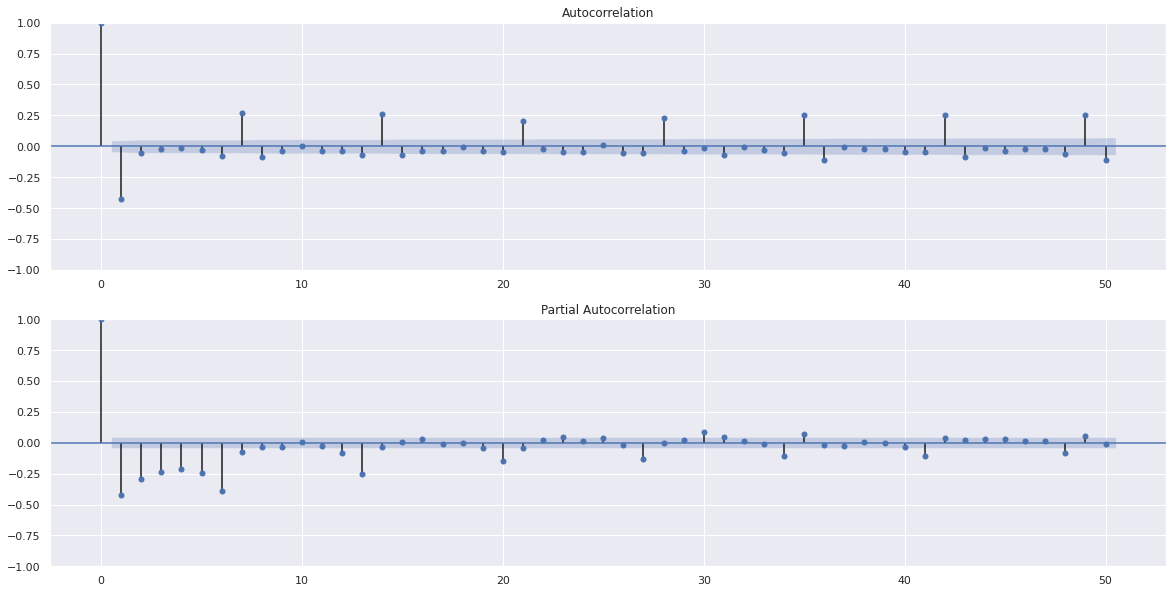

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(store_1_1_sales.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(store_1_1_sales.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From ACP plot we can determine order of MA to be 1.
From PACF plot we can determine order of AR to be 6.

In [ ]:
#order=(6, 1, 1) 
#first value is order of AR model . 6 here
#second value is order of Integration . 1 here.
#third value is order of MA model. 1 here.

In [ ]:
#seasonal_order=(1, 1, 1, 7) 
#first value is order of seasonal AR model . 1 here
#second value is order of seasonal Integration . 1 here.
#third value is order of seasonal MA model. 1 here.
#fourth value is seasonal value . We are taking 7 here.

In [ ]:
store_data_sarima = store_data.copy()
test_data_sarima = test_data.copy()

In [ ]:
#changing by log scale
store_data_sarima['sales'] = np.log1p(store_data_sarima['sales'])

In [ ]:
store_data_sarima.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
store_unique = store_data_sarima['store'].unique()
item_unique = store_data_sarima['item'].unique()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
for store in store_unique:
    for item in item_unique:
        store_sarima_train = store_data_sarima.loc[(store_data_sarima['store'] == store) & (store_data_sarima['item'] == item)]
        store_sarima_test = test_data_sarima.loc[(test_data_sarima['store'] == store) & (test_data_sarima['item'] == item)]
        
        # train sarima
        sarima_model = ARIMA(store_sarima_train['sales'].values, order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
        sarima_model_fit = sarima_model.fit()

        # make predictions
        sarima_pred = sarima_model_fit.predict(start=store_sarima_train.shape[0], end=store_sarima_train.shape[0]+store_sarima_test.shape[0]-1, dynamic=False)
        
        test_data_sarima.loc[(test_data_sarima['store'] == store) & (test_data_sarima['item'] == item), 'sales'] = np.expm1(sarima_pred)

In [ ]:
test_data_sarima.head()

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,12.767652
2018-01-02,1,1,1,14.928135
2018-01-03,2,1,1,15.414438
2018-01-04,3,1,1,16.131934
2018-01-05,4,1,1,17.268806


In [ ]:
submission['sales'] = np.round(test_data_sarima['sales'].values,0)

In [ ]:
submission.to_csv("sarima_submission.csv", index=False)

### **Score - 15.514**

## **Univariate models are not getting good score.Only exception here is AR model (lag value 91) and SARIMA which are getting decent score. The reason for this is data has  strong seasonal component.Univariate models are suited for non-seasonal data.**

# **5. Multivariate Models(Prophet,LGBM,XGBoost )**

## **5.1 Prophet**

In [ ]:
store_data_prophet = store_data.copy()

In [ ]:
#changing by log scale
store_data_prophet['sales'] = np.log1p(store_data_prophet['sales'])

In [ ]:
store_data_prophet.head()

,store,item,sales
date,,,
2013-01-01,1,1,2.639057
2013-01-02,1,1,2.484907
2013-01-03,1,1,2.708050
2013-01-04,1,1,2.639057
2013-01-05,1,1,2.397895


In [ ]:
prophet_test = test_data.reset_index()
prophet_test['sales'] = 0

In [ ]:
prophet_test.head()

,date,id,store,item,sales
0,2018-01-01,0,1,1,0
1,2018-01-02,1,1,1,0
2,2018-01-03,2,1,1,0
3,2018-01-04,3,1,1,0
4,2018-01-05,4,1,1,0


In [ ]:
#prophet modelling
from fbprophet import Prophet
for store in store_data_prophet['store'].unique():
    for item in store_data_prophet['item'].unique():
        store_prophet_train = store_data_prophet.loc[(store_data_prophet['store'] == store) & (store_data_prophet['item'] == item)].reset_index()
        store_prophet_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        prophet_model = Prophet(yearly_seasonality=4,  interval_width=0.95,changepoint_prior_scale=0.006, daily_seasonality=True)
        prophet_model.fit(store_prophet_train[['ds', 'y']])
        prophet_forecast = prophet_model.make_future_dataframe(periods=len(test_data.index.unique()), include_history=False)

        #making predictions
        forecast = prophet_model.predict(prophet_forecast)
        
        prophet_test.loc[(prophet_test['store'] == store) & (prophet_test['item'] == item), 'sales'] = np.expm1(forecast['yhat']).values

In [ ]:
prophet_test.drop(['date', 'store', 'item'], axis=1, inplace=True)

In [ ]:
prophet_test.head()

,id,sales
0,0,12.288596
1,1,14.354738
2,2,14.852995
3,3,15.331806
4,4,16.567544


In [ ]:
prophet_test.to_csv('prophet_submission.csv', index=False)

### **Score - 14.2 . This is good score.**

## **5.2 XGBoost**

In [ ]:
store_xgb_params = {'max_depth':3,
          'eta':0.2,
          'silent':1,
          'subsample':1}
num_rounds = 1500

In [ ]:
#train model
import xgboost as xgb
store_xgb_dtrain = xgb.DMatrix(X, label=Y, feature_names=list(X.columns))
store_xgb_dtest = xgb.DMatrix(test, feature_names=list(test.columns))

store_xgb_model = xgb.train(store_xgb_params, store_xgb_dtrain, num_rounds)

In [ ]:
#making predictions
store_xgb_preds = pd.Series(store_xgb_model.predict(store_xgb_dtest))

In [ ]:
store_xgb_preds_sales = np.round(np.expm1(store_xgb_preds.values),0)
submission['sales'] = store_xgb_preds_sales
submission.to_csv('xgb_submission.csv', index=False)

## **Score - 13.94**

## **5.3 LGBM**

In [ ]:
store_lgbm_columns = [column for column in store_final.columns if column not in ['date', 'id', 'sales', 'year']]

In [ ]:
iteration = 15000
                                                                                                       
store_lgbm_parms = {                                                                                                                            
        'nthread': -1,
        'metric': 'mae',
        'boosting_type': 'gbdt',    
        'max_depth': 7,
        'num_leaves': 28,   
        'task': 'train',                                                                                                                      
        'objective': 'regression_l1',                                                                                                         
        'learning_rate': 0.05,                                                                                                                
        'feature_fraction': 0.9,                                                                                                              
        'bagging_fraction': 0.8,                                                                                                              
        'bagging_freq': 5,                                                                                                                    
        'lambda_l1': 0.06,                                                                                                                    
        'lambda_l2': 0.05,                                                                                                                    
        'verbose': -1,     } 

In [ ]:
store_final.head()

,date,store,item,sales,day,month,year,dayofweek,id,dayofyear,weekofyear,weekend_yes,month_start_yes,month_end_yes,quarter,weekofmonth,mon_yes,tue_yes,wed_yes,thu_yes,fri_yes,sat_yes,sun_yes,exp_dayofweek,exp_weekofmonth,exp_weekofyear,exp_month,exp_quarter,exp_weekend_yes,l_8,l_15,l_22,l_29,l_30,l_31,l_38,l_61,l_67,l_73,l_91,...,item_33.0,item_34.0,item_35.0,item_36.0,item_37.0,item_38.0,item_39.0,item_40.0,item_41.0,item_42.0,item_43.0,item_44.0,item_45.0,item_46.0,item_47.0,item_48.0,item_49.0,item_50.0,item_nan,dayofweek_0.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0,dayofweek_nan,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,month_nan
0,2013-01-01,1,1,2.639057,1,1,2013,1,NaN,1,1,0,1,0,1,0.0,0,1,0,0,0,0,0,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,1,2.484907,2,1,2013,2,NaN,2,1,0,0,0,1,0.0,0,0,1,0,0,0,0,11.0,12.000000,12.000000,12.000000,12.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,2.708050,3,1,2013,3,NaN,3,1,0,0,0,1,0.0,0,0,0,1,0,0,0,14.0,12.666667,12.666667,12.666667,12.666667,12.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,2.639057,4,1,2013,4,NaN,4,1,1,0,0,1,0.0,0,0,0,0,1,0,0,13.0,12.750000,12.750000,12.750000,12.750000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,2.397895,5,1,2013,5,NaN,5,1,1,0,0,1,0.0,0,0,0,0,0,1,0,10.0,12.200000,12.200000,12.200000,12.200000,11.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = store_final[store_lgbm_columns] 
Y = store_final['sales']

In [ ]:
store_lgbm = store_final.loc[store_final.id.notnull()]                                                                                                                
test = store_lgbm[store_lgbm_columns] 

In [ ]:
import lightgbm as lgb                                                                                                                                                                                                                                                                                                                     
store_lgbm_dataset = lgb.Dataset(data=X, label=Y, feature_name=store_lgbm_columns)                                                                
store_lgbm_model = lgb.train(store_lgbm_parms, store_lgbm_dataset, num_boost_round=iteration)

In [ ]:
#making predictions
store_lgbm_preds = store_lgbm_model.predict(test, num_iteration=iteration)  

In [ ]:
store_lgbm_preds_sales = np.round(np.expm1(store_lgbm_preds),0)
submission['sales'] = store_lgbm_preds_sales
submission.to_csv('lgbm_submission.csv', index=False)

In [ ]:
store_lgbm_model.save_model('store_lgbm_model.txt') 

## **Score - 13.84 . Best score we got of all models**

# **6. Conclusions**

In [ ]:
from prettytable import PrettyTable

pretty1 = PrettyTable()
pretty1.field_names = ["Model", "Score"]

pretty2 = PrettyTable()
pretty2.field_names = ["Model", "Score"]

print("UniVariate Models")
pretty1.add_row(["AR(8)", 19.88])
pretty1.add_row(["AR(91)", 15.518])
pretty1.add_row(["MA", 25.28])
pretty1.add_row(["ARMA", 20.2])
pretty1.add_row(["ARIMA", 19.9])
pretty1.add_row(["SARIMA", 15.514])

print(pretty1)
print("\n")
print("MultiVariate Models")
pretty2.add_row(["Prophet", 14.2])
pretty2.add_row(["XGBoost", 13.94])
pretty2.add_row(["LGBM", 13.84])

print(pretty2)

UniVariate Models
+--------+--------+
| Model  | Score  |
+--------+--------+
| AR(8)  | 19.88  |
| AR(91) | 15.518 |
|   MA   | 25.28  |
|  ARMA  |  20.2  |
| ARIMA  |  19.9  |
| SARIMA | 15.514 |
+--------+--------+


MultiVariate Models
+---------+-------+
|  Model  | Score |
+---------+-------+
| Prophet |  14.2 |
| XGBoost | 13.94 |
|   LGBM  | 13.84 |
+---------+-------+
